In [ ]:
import numpy as np
import pandas as pd
from utils import create_buffers, crop_to_buffer, apply_cloud_mask, compute_ndvi, remove_builtup
from plot_chart import plot_ndvi_series

In [2]:
#### PATHS AND FILENAMES ####
# define input_data dir
data_dir = "input_data"
# define csv points filename
points_fn = "point_locations.csv"
# define tif filenames
tif_filenames = [
    "2025-02-02.tiff",
    "2025-03-14.tiff",
    "2025-04-25.tiff",
    "2025-05-13.tiff",
    "2025-07-25.tiff"
]

In [3]:
#### CONSTANTS ####
#define nodata value
NODATA = 32767
#define Red, NIR and Cloud Probability band indices
RED_IDX = 3
NIR_IDX = 7
CLOUD_PROB_IDX = 12


In [4]:
#### VARIABLES ####
#define cloud probability threshold
CLOUD_PROB_THRESHOLD = 50

#define ndvi std threshold
NDVI_STD_THRESH = 1000
NDVI_MIN_THRESH = 2000

#define buffer distance (in meters)
BUFFER_DIST = 1000

In [5]:
# create buffer around locations
buffers = create_buffers(data_dir, points_fn, BUFFER_DIST)

In [7]:
# create dictionary to store ndvi arrays for each buffer
ndvi_buffers = {}

# for each buffer, open images and crop to buffer
for i, b in enumerate(buffers):

    # create list to store ndvis
    ndvis_temp = []
    img_meta_temp = []

    geom = [b.__geo_interface__]

    for tif_filename in tif_filenames:

        cropped_img, img_meta, out_transform = crop_to_buffer(data_dir, tif_filename, geom, NODATA)

        #mask clouds
        cloudless_img = apply_cloud_mask(cropped_img, CLOUD_PROB_THRESHOLD, CLOUD_PROB_IDX, NODATA)
        #calculate ndvi
        ndvi = compute_ndvi(cloudless_img, RED_IDX, NIR_IDX, NODATA)

        ndvis_temp.append(ndvi)
        img_meta.update({
                "driver": "GTiff",
                "dtype": 'int16',
                "height": ndvi.shape[1],
                "width": ndvi.shape[2],
                "transform": out_transform,
                "count": 1,
                "nodata": NODATA
            })
        img_meta_temp.append(img_meta)

    #remove builtup areas - keep only areas that are likely to be vegetation
    ndvis_temp = remove_builtup(ndvis_temp, NODATA, NDVI_STD_THRESH, NDVI_MIN_THRESH)
    
    
    ndvi_buffers[i] = np.nanmean(np.stack(ndvis_temp), axis=(1,2))

df = pd.DataFrame(ndvi_buffers)

#extract tif dates
tif_dates = [f.replace('.tiff','') for f in tif_filenames]

#set dates as df index
df['dates'] = pd.to_datetime(tif_dates)
df = df.set_index('dates')

c:\Users\morae\anaconda3\envs\task_malta\lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\morae\Desktop\Ecostack_Innovations_Malta_Task\NDVI_Analysis_Task\utils.py:132: RuntimeWarning: All-NaN slice encountered
  ndvis_max = np.nanmax(ndvis_stacked, axis=0)
c:\Users\morae\anaconda3\envs\task_malta\lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\morae\Desktop\Ecostack_Innovations_Malta_Task\NDVI_Analysis_Task\utils.py:132: RuntimeWarning: All-NaN slice encountered
  ndvis_max = np.nanmax(ndvis_stacked, axis=0)
c:\Users\morae\anaconda3\envs\task_malta\lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\morae\D

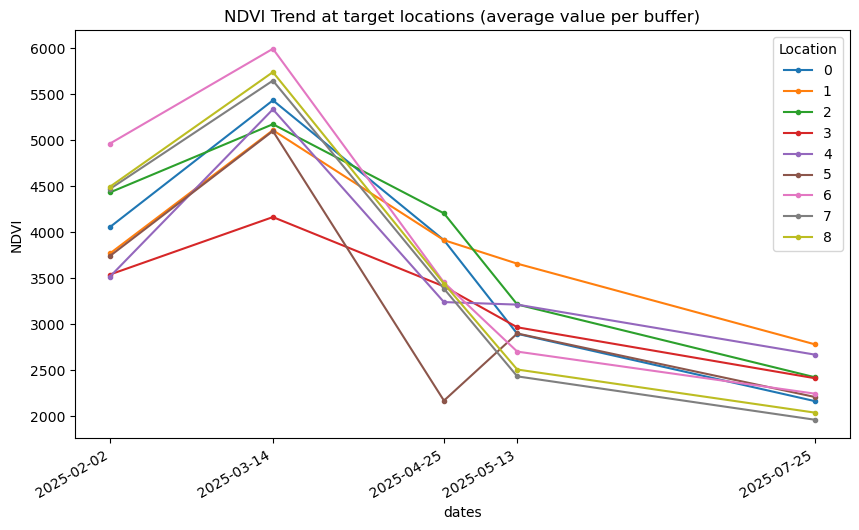

In [8]:
#plot NDVI time series
plot_ndvi_series(df)